In [1]:
!gdown 1kQUOrXNAWp5RjKohKV7W4QBnVppB9sLy
!gdown 1ghp6jX3JoB3nEH7vjzUGTotaWI4j4jYJ
!gdown 1Vp_IQEycgS7vWlFptUH_9iSs9JHpDLCj

Downloading...
From: https://drive.google.com/uc?id=1kQUOrXNAWp5RjKohKV7W4QBnVppB9sLy
To: /content/kmeans_model_for_BOVW_clustering.sav
100% 26.6M/26.6M [00:00<00:00, 211MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ghp6jX3JoB3nEH7vjzUGTotaWI4j4jYJ
To: /content/models_for_face_extraction.zip
100% 6.39M/6.39M [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vp_IQEycgS7vWlFptUH_9iSs9JHpDLCj
To: /content/models_NN_for_face_extraction.zip
100% 17.9M/17.9M [00:00<00:00, 192MB/s]


In [2]:
%%capture
!wget https://engineering.unl.edu/images/staff/Kayla-Person.jpg
!wget https://www.dmarge.com/wp-content/uploads/2021/01/dwayne-the-rock-.jpg

In [3]:
%%capture
!pip install chitra
!pip install -U opencv-python

In [4]:
%%capture
!unzip /content/models_for_face_extraction.zip
!unzip models_NN_for_face_extraction.zip

In [7]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import pickle
import cv2
from chitra.image import Chitra
from tensorflow import keras


In [8]:
### for feature extraction (BOWV) ###
feature_extractor = cv2.SIFT_create()
kmeans = pickle.load(open('kmeans_model_for_BOVW_clustering.sav', 'rb'))
num_visual_words = 512

### for bounding box generation ###
simple_nn = keras.models.load_model('/content/models/simple_dense')
simple_nn_skip = keras.models.load_model('/content/models/dense_with_skip')

In [19]:
def get_bowv_from_img(img_path):
  imagem_data = io.imread(img_path) 
  inicial_img_shape = imagem_data.shape
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2RGB)
  resize_img = cv2.resize(imagem_data, (480,480))
  _, sift_vectors = feature_extractor.detectAndCompute(imagem_data, None)

  hist = kmeans.predict(sift_vectors)
  hist = np.histogram(hist, num_visual_words)[0]

  return hist, resize_img, inicial_img_shape

def increase_by(val, to_inc):
  val += val * to_inc
  return min(val, 480)  

def decrese_by(val, to_inc):
  val -= val * to_inc
  return max(val, 0)

def expand_box(box, by_p=0.2):
  box[0] = decrese_by(box[0], by_p)
  box[1] = decrese_by(box[1], by_p)

  box[2] = increase_by(box[2], by_p)
  box[3] = increase_by(box[3], by_p)

def get_prediction_for_image(img_path, display=False, exp_by=0.0):

  bowv, resized_img, inicial_img_shape = get_bowv_from_img(img_path)

  bowv = bowv/np.sum(bowv)

  simple_nn_pred = simple_nn.predict(np.array([bowv]))[0] * 480
  simple_nn_skip_pred = simple_nn_skip.predict(np.array([bowv]))[0]  * 480
  
  expand_box(simple_nn_pred, exp_by)
  expand_box(simple_nn_skip_pred, exp_by)
  
  simple_nn_img = Chitra(np.array(resized_img), bboxes=simple_nn_pred, labels='face')
  simple_nn_img.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))
  
  skip_nn_img = Chitra(np.array(resized_img), bboxes=simple_nn_skip_pred, labels='face')
  skip_nn_img.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))

  return simple_nn_img, skip_nn_img

def plot_images(image_grad_boost, image_knn, plot_shape=(20,3), save_fig=False):

  plt.rcParams["figure.figsize"] = plot_shape
  fig, axs = plt.subplots(1,2)
  # fig.suptitle('images results')
  
  axs[0].imshow(cv2.cvtColor(image_grad_boost.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[0].set_title('Simple NN')
  axs[1].imshow(cv2.cvtColor(image_knn.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[1].set_title('Simple NN with skip')

  fig.patch.set_alpha(0.0)
  fig.show()
  if save_fig:
    cv2.imwrite('Simple NN.png', image_grad_boost.draw_boxes())
    cv2.imwrite('Simple NN with skip.png', image_knn.draw_boxes())

In [28]:
simple_nn_img, skip_nn_img = get_prediction_for_image('/content/Kayla-Person.jpg', exp_by=0.25)

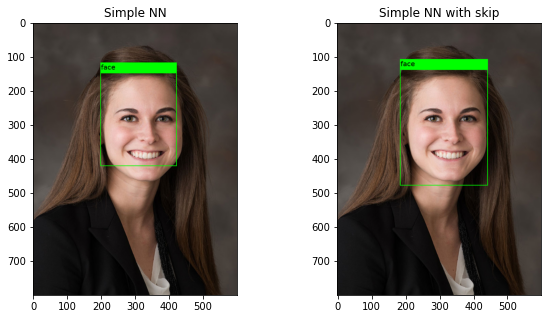

In [29]:
plot_images(simple_nn_img, skip_nn_img, plot_shape=(10,5), save_fig=True)